### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import os
from datetime import datetime
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingWarmRestarts
import torchvision
from torchvision import models
from apex import amp

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, TilesTrainDataset, LazyTilesDataset

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix)

# Nets
from chestxray.nets import TinyV2ConvNet, make_RN50_cls, freeze_botom
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)
# Losses
from chestxray.losses import LabelSmoothSoftmaxCEV1

# Optim
from chestxray.optimizers import RAdam

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Fix Random Seed

In [6]:
seed_torch()

### Load Data

In [7]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


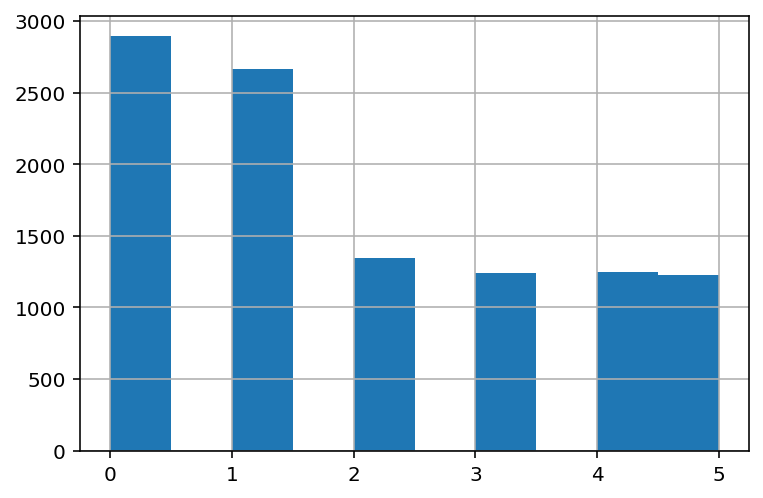

In [8]:
_ = TRAIN_DF[CFG.target_col].hist()

### Define Global Variables

In [9]:
CFG.debug = False
now = datetime.now()

EXP_NAME = now.strftime("%d-%m-%Y-%H-%M")
print(EXP_NAME)

17-05-2020-18-14


In [10]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/{EXP_NAME}')

In [11]:
LOSSES = {
    "cce" : nn.CrossEntropyLoss(),
    "ls_soft_ce" : LabelSmoothSoftmaxCEV1(),
}

In [12]:
# key - string, value - tuple(sceduler, if it epoch type)
epoch_type = True
SCHEDULERS = {
    "reduce_on_plateau" : (ReduceLROnPlateau, epoch_type),
    "one_cycle": (OneCycleLR, not epoch_type),
    "cawr": (CosineAnnealingWarmRestarts, not epoch_type)
}

### Train Eval Loop

In [22]:
def train_eval_loop(train_dataloader, val_dataloader, model, optimizer, criterion, scheduler, sch_is_epoch_type, checkpoint=False,
                    num_epochs=CFG.epoch, device=device, tb_tag="", model_name="debug"):
    """Split it into the set of inner functions to siplify the loop itself"""
    # Inner Functions
    # write to TensorBoard helpers
    def weights_to_tb(step=0):
        conv1_weight = model.conv1.weight.data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight, normalize=True)
        writer.add_image(tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=step)
    
    def input_img_to_tb(inputs, step):
        img = reverse_show_img(inputs[0])
        writer.add_image(tag=f"Input Image {tb_tag}", img_tensor=img, global_step=step, dataformats="HWC")
        del img
    
    def preds_to_tb(outputs, inputs, labels, step):
        figure=plot_classes_preds(outputs.to('cpu'), inputs.to('cpu'), labels.to('cpu'))
        writer.add_figure(tag=f"Actuals vs Predictions {tb_tag}", figure=figure, global_step=step)
        
    def metrics_to_tb(mode, train_loss, train_score, val_loss, val_score, step):
        writer.add_text(f"On best {mode} save:", 
                        f"tr_loss: {train_loss:.4f}, tr_qwk: {train_score:.4f}, val_loss: {val_loss:.4f}, val_qwk: {val_score:.4f}", 
                        global_step=step)
    
    def conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, step):
        writer.add_figure(tag=f"Confusion matrix {tb_tag}", figure=plot_confusion_matrix(val_epoch_labels, val_epoch_preds),
                          global_step=step)
        
        
    
    # Train/Eval Loop
    # write first layer weights to TB @ init phase
    if not CFG.debug:
        weights_to_tb()
    
    # prepare model and optimizer
    model.to(device)
    if CFG.use_amp: # automatic mixed precision
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
    # define epochs numbers to look into input images and predictions, no more than 10 times per full training
    vis_step = np.ceil(num_epochs/10).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    # metrics to wathch for model checkpointing
    best_qwk = -100 if not checkpoint else checkpoint['best_qwk']
    best_val_loss = np.inf if not checkpoint else checkpoint["best_val_loss"]
    
    start_epoch = 0 if not checkpoint else checkpoint["epoch"] + 1
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('=' * 10)

        # Training Phase
        # Set training mode
        model.train();
        train_running_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []

        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step for TensorBoard
            train_global_step = epoch * len(train_dataloader) + i

            inputs, labels = data
            # Visualize input before model at the middle of epoch:
            if epoch in visual_epochs and i == len(train_dataloader) // 2:
                input_img_to_tb(inputs, train_global_step)

            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            optimizer.step()
            # loss is mean across batch, divide by number of steps in epoch (so loss is normalized)
            train_running_loss += loss.item() / len(train_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Training loss {tb_tag}", scalar_value=loss.item(), global_step=train_global_step)

            # collect train preds and labels for QWK
            train_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            train_epoch_labels.append(labels.to('cpu').numpy())
            # Add Batch Type Scheduler step here:
            if not sch_is_epoch_type:
                scheduler.step()
        # Validation Phase
        # Set evaluation mode
        model.eval();
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag=f"Validation loss {tb_tag}", scalar_value=loss.item(), global_step=val_global_step)

            # collect validation preds and labels for QWK
            val_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            val_epoch_labels.append(labels.to('cpu').numpy())

            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                preds_to_tb(outputs, inputs, labels, val_global_step)
        
        # Epoch type Schedulers
        if sch_is_epoch_type:
            scheduler.step(val_running_loss)
        # Write lr to TBD
        if CFG.finetune == "1stage":
            writer.add_scalar(tag=f"lr Interim {tb_tag}:", scalar_value=optimizer.param_groups[0]["lr"], global_step=train_global_step)
            writer.add_scalar(tag=f"lr Classifier {tb_tag}:", scalar_value=optimizer.param_groups[1]["lr"], global_step=train_global_step)
            
        else:
            writer.add_scalar(tag=f"lr {tb_tag}:", scalar_value=optimizer.param_groups[0]["lr"], global_step=train_global_step)
        
        # "End of Epoch" Phase
        print(f'Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}')
        
        # Calculate epoch predictions distribution
        train_epoch_preds = np.concatenate(train_epoch_preds)
        train_epoch_labels = np.concatenate(train_epoch_labels)
        val_epoch_preds = np.concatenate(val_epoch_preds)
        val_epoch_labels = np.concatenate(val_epoch_labels)
        print(f'Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}')
        # Calculate epoch QWK
        train_qwk = cohen_kappa_score(train_epoch_preds, train_epoch_labels, weights='quadratic')
        val_qwk = cohen_kappa_score(val_epoch_preds, val_epoch_labels, weights='quadratic')
        print(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch)
        writer.add_scalar(tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch)
        
        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            print(f'  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_qwk': best_qwk,
            }, f'{MODEL_PATH}/{model_name}_loss.pth')
            # add losses as text to TB
            metrics_to_tb("loss", train_running_loss, train_qwk, val_running_loss, val_qwk, val_global_step)
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
        # On the best QWK
        if val_qwk > best_qwk:
            # update best and save model
            best_qwk = val_qwk
            print(f'  Epoch {epoch} - Save Best QWK: {best_qwk:.4f} Model')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_qwk': best_qwk,
            }, f'{MODEL_PATH}/{model_name}_qwk.pth')
            # add losses and qwk as text to TB
            metrics_to_tb("qwk", train_running_loss, train_qwk, val_running_loss, val_qwk, val_global_step)
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)  
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
    # End of loop
    writer.close()

### Prepare CV - strategy

In [14]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=100, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [15]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

In [16]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
 4   fold           10616 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 414.8+ KB


### Debug Runs

In [18]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/debug')

In [19]:
print(" ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False use_amp: True img_height: 512 img_width: 512 lr: 0.0001 batch_size: 16 epoch: 50 seed: 1982 target_size: 6 img_id_col: image_id target_col: isup_grade n_fold: 4 tiff_layer: 1 loss: ls_soft_ce


In [18]:
writer.add_text("Experiment Description:", " ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

In [22]:
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug="heavy"), debug=False) # NOTE! it is predefined 36-tiles images
val_ds = LazyTilesDataset(val_df, transform=get_transforms(data="valid"), debug=False)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = LOSSES[CFG.loss]
optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
train_eval_loop(train_ds, val_ds, model_ft, optimizer, criterion, num_epochs=30)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/29


100%|██████████| 166/166 [00:15<00:00, 10.67it/s]


Training Loss: 1.4133	Validation Loss: 1.3378
Counter train preds: Counter({0: 3171, 1: 2178, 5: 974, 3: 583, 4: 559, 2: 497})	Counter val preds: Counter({1: 964, 0: 951, 2: 237, 4: 185, 3: 164, 5: 153})
Epoch train QWK: 0.590	val QWK: 0.636
  Epoch 0 - Save Best Loss: 1.3378 Model
Confusion matrix, without normalization
[[612 104   1   1   2   3]
 [171 461  26   6   1   1]
 [ 38 220  61  10   4   2]
 [ 41  82  90  60  23  15]
 [ 50  69  31  37  95  31]
 [ 39  28  28  50  60 101]]
  Epoch 0 - Save Best QWK: 0.6357 Model
Confusion matrix, without normalization
[[612 104   1   1   2   3]
 [171 461  26   6   1   1]
 [ 38 220  61  10   4   2]
 [ 41  82  90  60  23  15]
 [ 50  69  31  37  95  31]
 [ 39  28  28  50  60 101]]
Epoch 1/29


100%|██████████| 166/166 [00:14<00:00, 11.12it/s]


Training Loss: 1.3243	Validation Loss: 1.2604
Counter train preds: Counter({0: 3068, 1: 2105, 5: 931, 3: 659, 4: 614, 2: 585})	Counter val preds: Counter({0: 1165, 5: 408, 1: 357, 2: 345, 3: 195, 4: 184})
Epoch train QWK: 0.663	val QWK: 0.723
  Epoch 1 - Save Best Loss: 1.2604 Model
Confusion matrix, without normalization
[[694  10   2   1   7   9]
 [271 243 116  20  13   3]
 [ 64  69 137  37  19   9]
 [ 47  18  54  85  32  75]
 [ 51  14  22  32  88 106]
 [ 38   3  14  20  25 206]]
  Epoch 1 - Save Best QWK: 0.7233 Model
Confusion matrix, without normalization
[[694  10   2   1   7   9]
 [271 243 116  20  13   3]
 [ 64  69 137  37  19   9]
 [ 47  18  54  85  32  75]
 [ 51  14  22  32  88 106]
 [ 38   3  14  20  25 206]]
Epoch 2/29


100%|██████████| 166/166 [00:14<00:00, 11.36it/s]


Training Loss: 1.2768	Validation Loss: 1.2445
Counter train preds: Counter({0: 2990, 1: 2062, 5: 903, 4: 712, 2: 654, 3: 641})	Counter val preds: Counter({0: 988, 1: 664, 5: 486, 3: 310, 4: 129, 2: 77})
Epoch train QWK: 0.694	val QWK: 0.724
  Epoch 2 - Save Best Loss: 1.2445 Model
Confusion matrix, without normalization
[[652  50   1   2   7  11]
 [178 413  27  28  11   9]
 [ 37 139  36  81  13  29]
 [ 43  31   6 118  19  94]
 [ 40  26   6  55  64 122]
 [ 38   5   1  26  15 221]]
  Epoch 2 - Save Best QWK: 0.7243 Model
Confusion matrix, without normalization
[[652  50   1   2   7  11]
 [178 413  27  28  11   9]
 [ 37 139  36  81  13  29]
 [ 43  31   6 118  19  94]
 [ 40  26   6  55  64 122]
 [ 38   5   1  26  15 221]]
Epoch 3/29


100%|██████████| 166/166 [00:16<00:00, 10.25it/s]


Training Loss: 1.2524	Validation Loss: 1.2349
Counter train preds: Counter({0: 2952, 1: 2107, 5: 934, 3: 729, 4: 638, 2: 602})	Counter val preds: Counter({1: 836, 0: 797, 5: 349, 3: 253, 4: 229, 2: 190})
Epoch train QWK: 0.708	val QWK: 0.764
  Epoch 3 - Save Best Loss: 1.2349 Model
Confusion matrix, without normalization
[[583 127   1   0   7   5]
 [118 459  66  14   9   0]
 [ 22 150  84  61  10   8]
 [ 25  42  21 112  56  55]
 [ 21  46  14  38 112  82]
 [ 28  12   4  28  35 199]]
  Epoch 3 - Save Best QWK: 0.7642 Model
Confusion matrix, without normalization
[[583 127   1   0   7   5]
 [118 459  66  14   9   0]
 [ 22 150  84  61  10   8]
 [ 25  42  21 112  56  55]
 [ 21  46  14  38 112  82]
 [ 28  12   4  28  35 199]]
Epoch 4/29


100%|██████████| 166/166 [00:15<00:00, 10.78it/s]

Training Loss: 1.2235	Validation Loss: 1.2475
Counter train preds: Counter({0: 2866, 1: 2110, 5: 923, 4: 713, 3: 677, 2: 673})	Counter val preds: Counter({0: 1068, 1: 627, 4: 370, 3: 248, 5: 245, 2: 96})
Epoch train QWK: 0.727	val QWK: 0.739
Epoch 5/29



100%|██████████| 166/166 [00:14<00:00, 11.65it/s]


Training Loss: 1.2193	Validation Loss: 1.2217
Counter train preds: Counter({0: 2865, 1: 2125, 5: 921, 3: 716, 4: 712, 2: 623})	Counter val preds: Counter({1: 887, 0: 850, 3: 307, 4: 232, 2: 218, 5: 160})
Epoch train QWK: 0.735	val QWK: 0.727
  Epoch 5 - Save Best Loss: 1.2217 Model
Confusion matrix, without normalization
[[616  87   2   3   9   6]
 [134 488  24  17   3   0]
 [ 20 209  74  22   7   3]
 [ 28  46  73 130  19  15]
 [ 26  48  24  68 123  24]
 [ 26   9  21  67  71 112]]
Epoch 6/29


100%|██████████| 166/166 [00:15<00:00, 10.50it/s]

Training Loss: 1.1916	Validation Loss: 1.2237
Counter train preds: Counter({0: 2830, 1: 2097, 5: 913, 3: 743, 4: 722, 2: 657})	Counter val preds: Counter({1: 895, 0: 872, 3: 277, 5: 261, 2: 209, 4: 140})
Epoch train QWK: 0.751	val QWK: 0.734
Epoch 7/29



100%|██████████| 166/166 [00:14<00:00, 11.43it/s]

Training Loss: 1.1780	Validation Loss: 1.2794
Counter train preds: Counter({0: 2802, 1: 2125, 5: 923, 4: 728, 3: 724, 2: 660})	Counter val preds: Counter({0: 1195, 1: 461, 5: 338, 4: 308, 2: 241, 3: 111})
Epoch train QWK: 0.760	val QWK: 0.724
Epoch 8/29



  6%|▋         | 32/498 [00:10<02:30,  3.10it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.45it/s]

Training Loss: 1.1537	Validation Loss: 1.2326
Counter train preds: Counter({0: 2766, 1: 2073, 5: 922, 4: 753, 2: 727, 3: 721})	Counter val preds: Counter({0: 970, 1: 600, 4: 415, 5: 261, 2: 222, 3: 186})
Epoch train QWK: 0.775	val QWK: 0.742
Epoch 9/29



100%|██████████| 166/166 [00:17<00:00,  9.62it/s]

Epoch    10: reducing learning rate of group 0 to 5.0000e-05.
Training Loss: 1.1571	Validation Loss: 1.2449
Counter train preds: Counter({0: 2746, 1: 2079, 5: 912, 3: 791, 4: 745, 2: 689})	Counter val preds: Counter({1: 1001, 0: 814, 5: 246, 2: 221, 3: 219, 4: 153})
Epoch train QWK: 0.767	val QWK: 0.717
Epoch 10/29



100%|██████████| 166/166 [00:14<00:00, 11.80it/s]


Training Loss: 1.0783	Validation Loss: 1.1852
Counter train preds: Counter({0: 2674, 1: 2077, 5: 928, 4: 786, 3: 769, 2: 728})	Counter val preds: Counter({0: 872, 1: 686, 5: 383, 4: 269, 3: 233, 2: 211})
Epoch train QWK: 0.814	val QWK: 0.762
  Epoch 10 - Save Best Loss: 1.1852 Model
Confusion matrix, without normalization
[[633  62   2   5  11  10]
 [139 424  55  26  22   0]
 [ 22 136  95  43  22  17]
 [ 27  31  33 110  43  67]
 [ 27  27  19  35 128  77]
 [ 24   6   7  14  43 212]]
Epoch 11/29


100%|██████████| 166/166 [00:14<00:00, 11.79it/s]


Training Loss: 1.0550	Validation Loss: 1.2170
Counter train preds: Counter({0: 2645, 1: 2025, 5: 936, 4: 803, 2: 797, 3: 756})	Counter val preds: Counter({0: 968, 1: 566, 5: 453, 2: 265, 3: 220, 4: 182})
Epoch train QWK: 0.819	val QWK: 0.766
  Epoch 11 - Save Best QWK: 0.7663 Model
Confusion matrix, without normalization
[[662  45   2   4   3   7]
 [181 366  84  13  15   7]
 [ 35  99 121  45  16  19]
 [ 32  23  34 109  27  86]
 [ 31  29  15  38  97 103]
 [ 27   4   9  11  24 231]]
Epoch 12/29


  8%|▊         | 42/498 [00:13<02:11,  3.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:16<00:00, 10.31it/s]

Training Loss: 1.0295	Validation Loss: 1.2241
Counter train preds: Counter({0: 2631, 1: 2021, 5: 895, 2: 815, 4: 801, 3: 799})	Counter val preds: Counter({0: 921, 1: 797, 5: 258, 3: 255, 4: 222, 2: 201})
Epoch train QWK: 0.821	val QWK: 0.754
Epoch 13/29



100%|██████████| 166/166 [00:14<00:00, 11.82it/s]

Training Loss: 1.0086	Validation Loss: 1.2355
Counter train preds: Counter({0: 2553, 1: 2047, 5: 940, 2: 815, 4: 813, 3: 794})	Counter val preds: Counter({0: 995, 1: 581, 2: 387, 5: 293, 3: 214, 4: 184})
Epoch train QWK: 0.843	val QWK: 0.752
Epoch 14/29



100%|██████████| 166/166 [00:14<00:00, 11.78it/s]

Epoch    15: reducing learning rate of group 0 to 2.5000e-05.
Training Loss: 0.9891	Validation Loss: 1.2672
Counter train preds: Counter({0: 2550, 1: 2031, 5: 919, 3: 833, 2: 832, 4: 797})	Counter val preds: Counter({0: 854, 1: 731, 4: 385, 5: 364, 2: 190, 3: 130})
Epoch train QWK: 0.844	val QWK: 0.763
Epoch 15/29



100%|██████████| 166/166 [00:15<00:00, 10.71it/s]


Training Loss: 0.9256	Validation Loss: 1.2372
Counter train preds: Counter({0: 2517, 1: 2001, 5: 894, 2: 886, 4: 846, 3: 818})	Counter val preds: Counter({0: 888, 1: 612, 3: 362, 2: 285, 5: 260, 4: 247})
Epoch train QWK: 0.868	val QWK: 0.767
  Epoch 15 - Save Best QWK: 0.7666 Model
Confusion matrix, without normalization
[[631  70   3  13   2   4]
 [146 389  85  35   9   2]
 [ 27  98 137  56  13   4]
 [ 30  21  39 151  38  32]
 [ 30  21  15  67 135  45]
 [ 24  13   6  40  50 173]]
Epoch 16/29


 13%|█▎        | 67/498 [00:20<02:05,  3.43it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.39it/s]

Training Loss: 0.9068	Validation Loss: 1.2451
Counter train preds: Counter({0: 2501, 1: 1981, 5: 924, 2: 901, 3: 831, 4: 824})	Counter val preds: Counter({0: 868, 1: 740, 2: 287, 3: 280, 5: 247, 4: 232})
Epoch train QWK: 0.876	val QWK: 0.754
Epoch 17/29



100%|██████████| 166/166 [00:15<00:00, 10.44it/s]

Training Loss: 0.8845	Validation Loss: 1.2586
Counter train preds: Counter({0: 2483, 1: 1987, 5: 913, 2: 888, 4: 866, 3: 825})	Counter val preds: Counter({0: 844, 1: 579, 5: 348, 3: 298, 2: 296, 4: 289})
Epoch train QWK: 0.881	val QWK: 0.764
Epoch 18/29



100%|██████████| 166/166 [00:15<00:00, 10.56it/s]

Epoch    19: reducing learning rate of group 0 to 1.2500e-05.
Training Loss: 0.8628	Validation Loss: 1.2978
Counter train preds: Counter({0: 2465, 1: 1989, 5: 915, 2: 894, 4: 864, 3: 835})	Counter val preds: Counter({0: 817, 1: 634, 2: 407, 5: 305, 3: 289, 4: 202})
Epoch train QWK: 0.893	val QWK: 0.763
Epoch 19/29



100%|██████████| 166/166 [00:14<00:00, 11.44it/s]


Training Loss: 0.8329	Validation Loss: 1.2674
Counter train preds: Counter({0: 2413, 1: 2033, 2: 935, 5: 906, 4: 867, 3: 808})	Counter val preds: Counter({0: 843, 1: 638, 2: 380, 5: 292, 4: 253, 3: 248})
Epoch train QWK: 0.897	val QWK: 0.771
  Epoch 19 - Save Best QWK: 0.7708 Model
Confusion matrix, without normalization
[[617  87   7   4   3   5]
 [127 398 113  17   7   4]
 [ 23  95 157  44  13   3]
 [ 25  24  64 112  44  42]
 [ 24  25  26  42 135  61]
 [ 27   9  13  29  51 177]]
Epoch 20/29


 18%|█▊        | 90/498 [00:28<02:00,  3.39it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.74it/s]


Training Loss: 0.8309	Validation Loss: 1.2587
Counter train preds: Counter({0: 2444, 1: 1971, 2: 946, 5: 906, 4: 855, 3: 840})	Counter val preds: Counter({0: 905, 1: 645, 5: 348, 2: 288, 4: 254, 3: 214})
Epoch train QWK: 0.895	val QWK: 0.772
  Epoch 20 - Save Best QWK: 0.7721 Model
Confusion matrix, without normalization
[[638  67   7   5   2   4]
 [156 399  82  11  13   5]
 [ 27 112 129  38  19  10]
 [ 30  31  46 104  49  51]
 [ 29  25  16  32 137  74]
 [ 25  11   8  24  34 204]]
Epoch 21/29


100%|██████████| 166/166 [00:16<00:00, 10.07it/s]

Training Loss: 0.8118	Validation Loss: 1.2990
Counter train preds: Counter({0: 2425, 1: 1992, 2: 920, 5: 913, 4: 863, 3: 849})	Counter val preds: Counter({0: 863, 1: 560, 2: 397, 4: 287, 3: 274, 5: 273})
Epoch train QWK: 0.904	val QWK: 0.766
Epoch 22/29



100%|██████████| 166/166 [00:14<00:00, 11.43it/s]


Epoch    23: reducing learning rate of group 0 to 6.2500e-06.
Training Loss: 0.8106	Validation Loss: 1.2867
Counter train preds: Counter({0: 2392, 1: 2022, 2: 934, 5: 910, 4: 880, 3: 824})	Counter val preds: Counter({0: 844, 1: 588, 2: 388, 5: 310, 4: 274, 3: 250})
Epoch train QWK: 0.898	val QWK: 0.773
  Epoch 22 - Save Best QWK: 0.7731 Model
Confusion matrix, without normalization
[[610  87  10   6   5   5]
 [139 365 121  26  10   5]
 [ 24  80 164  46  17   4]
 [ 21  24  62 114  45  45]
 [ 25  24  18  39 147  60]
 [ 25   8  13  19  50 191]]
Epoch 23/29


100%|██████████| 166/166 [00:14<00:00, 11.55it/s]

Training Loss: 0.7927	Validation Loss: 1.2908
Counter train preds: Counter({0: 2397, 1: 1984, 5: 944, 2: 931, 3: 874, 4: 832})	Counter val preds: Counter({0: 840, 1: 644, 2: 377, 5: 274, 3: 270, 4: 249})
Epoch train QWK: 0.906	val QWK: 0.766
Epoch 24/29



 41%|████      | 204/498 [01:01<01:24,  3.47it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:15<00:00, 10.47it/s]

Training Loss: 0.7887	Validation Loss: 1.2833
Counter train preds: Counter({0: 2403, 1: 1975, 2: 947, 5: 891, 4: 890, 3: 856})	Counter val preds: Counter({0: 863, 1: 672, 2: 376, 4: 297, 5: 265, 3: 181})
Epoch train QWK: 0.906	val QWK: 0.760
Epoch 25/29



100%|██████████| 166/166 [00:14<00:00, 11.74it/s]

Training Loss: 0.7820	Validation Loss: 1.2766
Counter train preds: Counter({0: 2399, 1: 1977, 2: 951, 5: 904, 4: 874, 3: 857})	Counter val preds: Counter({0: 859, 1: 629, 2: 323, 3: 313, 5: 275, 4: 255})
Epoch train QWK: 0.907	val QWK: 0.765
Epoch 26/29



100%|██████████| 166/166 [00:14<00:00, 11.55it/s]

Epoch    27: reducing learning rate of group 0 to 3.1250e-06.
Training Loss: 0.7875	Validation Loss: 1.2824
Counter train preds: Counter({0: 2443, 1: 1964, 2: 935, 5: 905, 3: 877, 4: 838})	Counter val preds: Counter({0: 838, 1: 655, 2: 371, 5: 292, 3: 290, 4: 208})
Epoch train QWK: 0.906	val QWK: 0.759
Epoch 27/29



100%|██████████| 166/166 [00:15<00:00, 10.60it/s]

Training Loss: 0.7610	Validation Loss: 1.3068
Counter train preds: Counter({0: 2411, 1: 1954, 2: 952, 5: 937, 4: 861, 3: 847})	Counter val preds: Counter({0: 886, 1: 561, 2: 348, 3: 338, 5: 284, 4: 237})
Epoch train QWK: 0.917	val QWK: 0.759
Epoch 28/29



 51%|█████▏    | 256/498 [01:17<01:09,  3.46it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


100%|██████████| 166/166 [00:14<00:00, 11.39it/s]

Training Loss: 0.7612	Validation Loss: 1.2853
Counter train preds: Counter({0: 2396, 1: 1962, 2: 947, 5: 916, 4: 880, 3: 861})	Counter val preds: Counter({0: 855, 1: 665, 2: 342, 5: 313, 3: 248, 4: 231})
Epoch train QWK: 0.917	val QWK: 0.764
Epoch 29/29



100%|██████████| 166/166 [00:14<00:00, 11.73it/s]

Training Loss: 0.7683	Validation Loss: 1.2812
Counter train preds: Counter({0: 2405, 1: 1990, 2: 934, 5: 886, 4: 880, 3: 867})	Counter val preds: Counter({0: 888, 1: 609, 2: 364, 5: 295, 3: 262, 4: 236})
Epoch train QWK: 0.914	val QWK: 0.762


### Experiment Run

In [17]:
print(" ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False
 seed: 1982
 img_height: 768
 img_width: 768
 target_size: 6
 img_id_col: image_id
 target_col: isup_grade
 tiff_layer: 1
 stoch_sample: True
 num_tiles: 36
 tile_sz: 128
 batch_size: 8
 use_lazy: False
 aug_type: light
 finetune: False
 model_cls: one_layer
 schedule_type: reduce_on_plateau
 cawr_T: 1
 cawr_Tmult: 2
 loss: ls_soft_ce
 optim: radam
 lr: 0.0003
 rlopp: 1
 epoch: 50
 n_fold: 4
 use_amp: True



In [18]:
writer.add_text("Experiment Description:", " ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

In [21]:
# schedulers
def get_scheduler(optimizer,train_dataloader, schedule_type=CFG.schedule_type, resume=False):
    assert schedule_type in SCHEDULERS, f"{schedule_type} not in SCHEDULERS"
    if schedule_type == "reduce_on_plateau":
        return (SCHEDULERS[schedule_type][0](optimizer, 'min', factor=0.5, patience=CFG.rlopp if not resume else CFG.rlopp + 2, verbose=True), 
                SCHEDULERS[schedule_type][1])
    if schedule_type == "one_cycle":
        return (SCHEDULERS[schedule_type][0](optimizer, max_lr=[CFG.lr, CFG.lr*10] if CFG.finetune == "1stage" else CFG.lr,
                                             steps_per_epoch=len(train_dataloader), epochs=CFG.epoch, pct_start=0.05),
                SCHEDULERS[schedule_type][1])
    if schedule_type == "cawr":
        return (SCHEDULERS[schedule_type][0](optimizer, T_0=len(train_dataloader)*CFG.cawr_T, T_mult=CFG.cawr_Tmult),
                SCHEDULERS[schedule_type][1])

In [20]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
# define datasets
if CFG.use_lazy:
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
else:
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False)
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=6)

model_ft = make_RN50_cls()
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr, momentum=0.9, nesterov=True)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr)
    
scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader)

train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, scheduler, sch_is_epoch_type, model_name=EXP_NAME)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 0/49


  0%|          | 0/996 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
100%|██████████| 332/332 [01:54<00:00,  2.91it/s]


Training Loss: 1.4196	Validation Loss: 1.4186
Counter train preds: Counter({0: 3206, 1: 2206, 5: 933, 4: 569, 3: 564, 2: 484})	Counter val preds: Counter({0: 1457, 1: 633, 2: 256, 5: 241, 4: 35, 3: 32})
Epoch train QWK: 0.564	val QWK: 0.461
  Epoch 0 - Save Best Loss: 1.4186 Model
Confusion matrix, without normalization
[[708  13   1   0   0   1]
 [291 330  43   1   1   0]
 [ 89 155  85   2   0   4]
 [102  76  80  12   2  39]
 [152  45  28  12  23  53]
 [115  14  19   5   9 144]]
  Epoch 0 - Save Best QWK: 0.4606 Model
Confusion matrix, without normalization
[[708  13   1   0   0   1]
 [291 330  43   1   1   0]
 [ 89 155  85   2   0   4]
 [102  76  80  12   2  39]
 [152  45  28  12  23  53]
 [115  14  19   5   9 144]]
Epoch 1/49


100%|██████████| 332/332 [01:51<00:00,  2.99it/s]


Training Loss: 1.3354	Validation Loss: 1.2961
Counter train preds: Counter({0: 2990, 1: 2210, 5: 955, 4: 689, 3: 569, 2: 549})	Counter val preds: Counter({0: 973, 1: 391, 5: 381, 2: 356, 4: 303, 3: 250})
Epoch train QWK: 0.646	val QWK: 0.725
  Epoch 1 - Save Best Loss: 1.2961 Model
Confusion matrix, without normalization
[[662  30   7   7  10   7]
 [166 269 166  47  11   7]
 [ 40  53 123  82  14  23]
 [ 34  16  34  66  59 102]
 [ 38  16  17  34 142  66]
 [ 33   7   9  14  67 176]]
  Epoch 1 - Save Best QWK: 0.7246 Model
Confusion matrix, without normalization
[[662  30   7   7  10   7]
 [166 269 166  47  11   7]
 [ 40  53 123  82  14  23]
 [ 34  16  34  66  59 102]
 [ 38  16  17  34 142  66]
 [ 33   7   9  14  67 176]]
Epoch 2/49


 47%|████▋     | 465/996 [02:47<03:05,  2.86it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.11it/s]


Training Loss: 1.3099	Validation Loss: 1.2313
Counter train preds: Counter({0: 2983, 1: 2195, 5: 965, 4: 675, 3: 608, 2: 536})	Counter val preds: Counter({0: 948, 1: 767, 5: 508, 3: 226, 2: 119, 4: 86})
Epoch train QWK: 0.665	val QWK: 0.724
  Epoch 2 - Save Best Loss: 1.2313 Model
Confusion matrix, without normalization
[[650  66   1   1   2   3]
 [136 470  33  22   3   2]
 [ 26 145  66  62   3  33]
 [ 45  38  10  88  14 116]
 [ 45  39   6  40  53 130]
 [ 46   9   3  13  11 224]]
Epoch 3/49


100%|██████████| 332/332 [01:47<00:00,  3.08it/s]


Training Loss: 1.2812	Validation Loss: 1.2633
Counter train preds: Counter({0: 2942, 1: 2196, 5: 1003, 4: 673, 3: 601, 2: 547})	Counter val preds: Counter({1: 1008, 0: 760, 5: 480, 2: 188, 3: 146, 4: 72})
Epoch train QWK: 0.677	val QWK: 0.742
  Epoch 3 - Save Best QWK: 0.7417 Model
Confusion matrix, without normalization
[[589 112   1   1   2  18]
 [ 90 551  11   4   2   8]
 [ 15 203  79  23   2  13]
 [ 23  68  64  62  10  84]
 [ 25  59  18  37  37 137]
 [ 18  15  15  19  19 220]]
Epoch 4/49


 60%|█████▉    | 595/996 [03:30<02:19,  2.87it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.11it/s]

Epoch     5: reducing learning rate of group 0 to 1.5000e-04.
Training Loss: 1.2646	Validation Loss: 1.2980
Counter train preds: Counter({0: 2921, 1: 2294, 5: 964, 4: 653, 3: 606, 2: 524})	Counter val preds: Counter({0: 1050, 1: 822, 3: 383, 4: 178, 5: 142, 2: 79})
Epoch train QWK: 0.684	val QWK: 0.681
Epoch 5/49



100%|██████████| 332/332 [01:46<00:00,  3.10it/s]


Training Loss: 1.2017	Validation Loss: 1.2230
Counter train preds: Counter({0: 2849, 1: 2213, 5: 929, 4: 735, 3: 643, 2: 593})	Counter val preds: Counter({0: 873, 1: 510, 3: 411, 5: 391, 4: 307, 2: 162})
Epoch train QWK: 0.741	val QWK: 0.785
  Epoch 5 - Save Best Loss: 1.2230 Model
Confusion matrix, without normalization
[[649  48   2   5   7  12]
 [143 360  75  72  10   6]
 [ 19  71  70 133  22  20]
 [ 28  14   9 117  69  74]
 [ 15  14   4  56 145  79]
 [ 19   3   2  28  54 200]]
  Epoch 5 - Save Best QWK: 0.7851 Model
Confusion matrix, without normalization
[[649  48   2   5   7  12]
 [143 360  75  72  10   6]
 [ 19  71  70 133  22  20]
 [ 28  14   9 117  69  74]
 [ 15  14   4  56 145  79]
 [ 19   3   2  28  54 200]]
Epoch 6/49


100%|██████████| 332/332 [01:46<00:00,  3.13it/s]


Training Loss: 1.1781	Validation Loss: 1.1740
Counter train preds: Counter({0: 2801, 1: 2170, 5: 912, 4: 759, 3: 672, 2: 648})	Counter val preds: Counter({1: 921, 0: 798, 3: 299, 5: 299, 2: 201, 4: 136})
Epoch train QWK: 0.756	val QWK: 0.773
  Epoch 6 - Save Best Loss: 1.1740 Model
Confusion matrix, without normalization
[[611 105   1   2   0   4]
 [ 90 534  29  11   2   0]
 [ 16 183  90  41   3   2]
 [ 34  44  47 138  17  31]
 [ 23  42  21  63  93  71]
 [ 24  13  13  44  21 191]]
Epoch 7/49


100%|██████████| 332/332 [01:45<00:00,  3.14it/s]

Training Loss: 1.1733	Validation Loss: 1.2070
Counter train preds: Counter({0: 2786, 1: 2199, 5: 925, 4: 735, 3: 671, 2: 646})	Counter val preds: Counter({0: 768, 1: 672, 5: 512, 2: 309, 4: 241, 3: 152})
Epoch train QWK: 0.755	val QWK: 0.771
Epoch 8/49



  0%|          | 1/996 [00:02<42:16,  2.55s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.12it/s]


Training Loss: 1.1565	Validation Loss: 1.1575
Counter train preds: Counter({0: 2722, 1: 2183, 5: 930, 4: 767, 2: 713, 3: 647})	Counter val preds: Counter({0: 880, 1: 764, 5: 365, 2: 288, 4: 234, 3: 123})
Epoch train QWK: 0.768	val QWK: 0.774
  Epoch 8 - Save Best Loss: 1.1575 Model
Confusion matrix, without normalization
[[663  39   1   0  11   9]
 [124 496  28   5  12   1]
 [ 18 160 130   6  10  11]
 [ 26  41  80  71  33  60]
 [ 22  23  31  24 128  85]
 [ 27   5  18  17  40 199]]
Epoch 9/49


100%|██████████| 332/332 [01:46<00:00,  3.11it/s]


Training Loss: 1.1546	Validation Loss: 1.1800
Counter train preds: Counter({0: 2765, 1: 2160, 5: 915, 4: 749, 3: 719, 2: 654})	Counter val preds: Counter({1: 1020, 0: 793, 5: 290, 4: 245, 3: 184, 2: 122})
Epoch train QWK: 0.766	val QWK: 0.786
  Epoch 9 - Save Best QWK: 0.7859 Model
Confusion matrix, without normalization
[[624  95   1   1   1   1]
 [ 88 557  10   5   6   0]
 [ 18 233  50  27   5   2]
 [ 21  68  43  97  40  42]
 [ 22  45  12  35 135  64]
 [ 20  22   6  19  58 181]]
Epoch 10/49


 67%|██████▋   | 664/996 [03:55<01:50,  3.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.11it/s]

Epoch    11: reducing learning rate of group 0 to 7.5000e-05.
Training Loss: 1.1425	Validation Loss: 1.1803
Counter train preds: Counter({0: 2750, 1: 2146, 5: 940, 4: 733, 3: 702, 2: 691})	Counter val preds: Counter({0: 755, 1: 749, 5: 433, 4: 267, 2: 240, 3: 210})
Epoch train QWK: 0.781	val QWK: 0.770
Epoch 11/49



100%|██████████| 332/332 [01:46<00:00,  3.12it/s]


Training Loss: 1.1084	Validation Loss: 1.1177
Counter train preds: Counter({0: 2702, 1: 2160, 5: 908, 4: 757, 2: 732, 3: 703})	Counter val preds: Counter({0: 899, 1: 769, 5: 383, 3: 242, 2: 188, 4: 173})
Epoch train QWK: 0.790	val QWK: 0.802
  Epoch 11 - Save Best Loss: 1.1177 Model
Confusion matrix, without normalization
[[675  39   2   4   1   2]
 [123 506  23  10   1   3]
 [ 21 162 100  38   2  12]
 [ 32  30  41 116  24  68]
 [ 23  24  15  49 117  85]
 [ 25   8   7  25  28 213]]
  Epoch 11 - Save Best QWK: 0.8020 Model
Confusion matrix, without normalization
[[675  39   2   4   1   2]
 [123 506  23  10   1   3]
 [ 21 162 100  38   2  12]
 [ 32  30  41 116  24  68]
 [ 23  24  15  49 117  85]
 [ 25   8   7  25  28 213]]
Epoch 12/49


100%|██████████| 332/332 [01:46<00:00,  3.13it/s]

Training Loss: 1.0942	Validation Loss: 1.1240
Counter train preds: Counter({0: 2670, 1: 2138, 5: 892, 4: 786, 2: 746, 3: 730})	Counter val preds: Counter({0: 903, 1: 604, 3: 330, 5: 307, 2: 303, 4: 207})
Epoch train QWK: 0.799	val QWK: 0.801
Epoch 13/49



100%|██████████| 332/332 [01:52<00:00,  2.94it/s]


Training Loss: 1.0820	Validation Loss: 1.1044
Counter train preds: Counter({0: 2638, 1: 2148, 5: 900, 4: 802, 3: 738, 2: 736})	Counter val preds: Counter({0: 945, 1: 654, 5: 341, 2: 287, 3: 236, 4: 191})
Epoch train QWK: 0.804	val QWK: 0.796
  Epoch 13 - Save Best Loss: 1.1044 Model
Confusion matrix, without normalization
[[688  29   2   3   0   1]
 [142 457  49  14   4   0]
 [ 23 126 143  33   2   8]
 [ 32  16  63 109  32  59]
 [ 30  19  21  54 121  68]
 [ 30   7   9  23  32 205]]
Epoch 14/49


 62%|██████▏   | 620/996 [03:44<02:07,  2.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.13it/s]


Training Loss: 1.0783	Validation Loss: 1.1592
Counter train preds: Counter({0: 2674, 1: 2084, 5: 906, 2: 781, 4: 772, 3: 745})	Counter val preds: Counter({1: 1005, 0: 739, 5: 272, 4: 223, 3: 219, 2: 196})
Epoch train QWK: 0.814	val QWK: 0.802
  Epoch 14 - Save Best QWK: 0.8023 Model
Confusion matrix, without normalization
[[607 110   2   3   0   1]
 [ 66 578   8  11   2   1]
 [  9 219  82  20   3   2]
 [ 22  47  65 105  38  34]
 [ 18  39  23  50 136  47]
 [ 17  12  16  30  44 187]]
Epoch 15/49


100%|██████████| 332/332 [01:46<00:00,  3.12it/s]


Epoch    16: reducing learning rate of group 0 to 3.7500e-05.
Training Loss: 1.0711	Validation Loss: 1.1192
Counter train preds: Counter({0: 2663, 1: 2135, 5: 899, 4: 796, 2: 755, 3: 714})	Counter val preds: Counter({1: 812, 0: 767, 5: 401, 3: 261, 4: 212, 2: 201})
Epoch train QWK: 0.816	val QWK: 0.820
  Epoch 15 - Save Best QWK: 0.8204 Model
Confusion matrix, without normalization
[[624  87   1   5   3   3]
 [ 77 526  36  18   6   3]
 [ 11 145 110  47  11  11]
 [ 21  25  38 121  39  67]
 [ 17  22  10  44 119 101]
 [ 17   7   6  26  34 216]]
Epoch 16/49


100%|██████████| 332/332 [01:45<00:00,  3.14it/s]


Training Loss: 1.0524	Validation Loss: 1.0801
Counter train preds: Counter({0: 2633, 1: 2094, 5: 881, 4: 805, 2: 802, 3: 747})	Counter val preds: Counter({0: 822, 1: 818, 2: 268, 4: 252, 5: 251, 3: 243})
Epoch train QWK: 0.832	val QWK: 0.816
  Epoch 16 - Save Best Loss: 1.0801 Model
Confusion matrix, without normalization
[[655  62   2   2   1   1]
 [ 86 537  29  12   1   1]
 [ 14 157 126  32   5   1]
 [ 27  31  69 118  43  23]
 [ 20  23  28  49 151  42]
 [ 20   8  14  30  51 183]]
Epoch 17/49


 27%|██▋       | 267/996 [01:35<04:03,  3.00it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.13it/s]


Training Loss: 1.0321	Validation Loss: 1.0940
Counter train preds: Counter({0: 2603, 1: 2119, 5: 862, 4: 835, 2: 779, 3: 764})	Counter val preds: Counter({0: 803, 1: 714, 5: 324, 3: 323, 4: 255, 2: 235})
Epoch train QWK: 0.835	val QWK: 0.827
  Epoch 17 - Save Best QWK: 0.8266 Model
Confusion matrix, without normalization
[[642  73   2   5   0   1]
 [ 85 485  68  20   5   3]
 [ 14 114 120  68  14   5]
 [ 24  19  29 152  48  39]
 [ 18  15  11  47 147  75]
 [ 20   8   5  31  41 201]]
Epoch 18/49


100%|██████████| 332/332 [01:45<00:00,  3.13it/s]

Epoch    19: reducing learning rate of group 0 to 1.8750e-05.
Training Loss: 1.0322	Validation Loss: 1.0833
Counter train preds: Counter({0: 2597, 1: 2119, 5: 883, 4: 832, 3: 767, 2: 764})	Counter val preds: Counter({0: 841, 1: 714, 5: 318, 2: 276, 3: 257, 4: 248})
Epoch train QWK: 0.830	val QWK: 0.824
Epoch 19/49



 60%|█████▉    | 596/996 [03:28<02:11,  3.05it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Training Loss: 1.0145	Validation Loss: 1.0876
Counter train preds: Counter({0: 2557, 1: 2099, 5: 885, 2: 838, 4: 819, 3: 764})	Counter val preds: Counter({0: 849, 1: 630, 2: 327, 3: 326, 5: 297, 4: 225})
Epoch train QWK: 0.842	val QWK: 0.825
Epoch 20/49



100%|██████████| 332/332 [01:52<00:00,  2.96it/s]

Epoch    21: reducing learning rate of group 0 to 9.3750e-06.
Training Loss: 1.0154	Validation Loss: 1.0816
Counter train preds: Counter({0: 2595, 1: 2123, 5: 864, 4: 810, 2: 800, 3: 770})	Counter val preds: Counter({0: 804, 1: 724, 5: 317, 2: 294, 3: 270, 4: 245})
Epoch train QWK: 0.836	val QWK: 0.825
Epoch 21/49



 82%|████████▏ | 815/996 [05:06<01:00,  2.99it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:52<00:00,  2.96it/s]

Training Loss: 0.9981	Validation Loss: 1.0816
Counter train preds: Counter({0: 2581, 1: 2095, 5: 861, 4: 835, 3: 795, 2: 795})	Counter val preds: Counter({0: 794, 1: 765, 3: 340, 2: 261, 5: 259, 4: 235})
Epoch train QWK: 0.846	val QWK: 0.826
Epoch 22/49



100%|██████████| 996/996 [06:04<00:00,  2.73it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 332/332 [01:51<00:00,  2.98it/s]


Epoch    23: reducing learning rate of group 0 to 4.6875e-06.
Training Loss: 1.0011	Validation Loss: 1.0856
Counter train preds: Counter({0: 2565, 1: 2087, 5: 857, 4: 853, 2: 812, 3: 788})	Counter val preds: Counter({0: 776, 1: 733, 5: 353, 3: 310, 2: 245, 4: 237})
Epoch train QWK: 0.847	val QWK: 0.837
  Epoch 22 - Save Best QWK: 0.8371 Model
Confusion matrix, without normalization
[[639  75   2   5   1   1]
 [ 74 506  64  15   4   3]
 [ 12 105 134  62  11  11]
 [ 19  23  27 151  43  48]
 [ 18  15  13  51 140  76]
 [ 14   9   5  26  38 214]]
Epoch 23/49


100%|██████████| 332/332 [01:52<00:00,  2.96it/s]


Training Loss: 0.9927	Validation Loss: 1.0720
Counter train preds: Counter({0: 2574, 1: 2081, 5: 900, 4: 819, 2: 808, 3: 780})	Counter val preds: Counter({0: 802, 1: 741, 5: 297, 2: 276, 4: 275, 3: 263})
Epoch train QWK: 0.849	val QWK: 0.830
  Epoch 23 - Save Best Loss: 1.0720 Model
Confusion matrix, without normalization
[[648  68   2   3   1   1]
 [ 83 507  59  11   3   3]
 [ 11 119 146  42  10   7]
 [ 23  22  46 135  50  35]
 [ 19  15  15  46 162  56]
 [ 18  10   8  26  49 195]]
Epoch 24/49


100%|██████████| 332/332 [01:47<00:00,  3.08it/s]

Training Loss: 0.9907	Validation Loss: 1.0770
Counter train preds: Counter({0: 2568, 1: 2080, 5: 873, 4: 842, 2: 821, 3: 778})	Counter val preds: Counter({0: 817, 1: 707, 5: 325, 4: 289, 2: 265, 3: 251})
Epoch train QWK: 0.846	val QWK: 0.835
Epoch 25/49



100%|██████████| 332/332 [01:48<00:00,  3.06it/s]

Epoch    26: reducing learning rate of group 0 to 2.3437e-06.
Training Loss: 0.9941	Validation Loss: 1.0792
Counter train preds: Counter({0: 2571, 1: 2105, 5: 856, 4: 843, 2: 821, 3: 766})	Counter val preds: Counter({0: 793, 1: 724, 3: 339, 5: 301, 4: 249, 2: 248})
Epoch train QWK: 0.847	val QWK: 0.833
Epoch 26/49



100%|██████████| 332/332 [01:49<00:00,  3.02it/s]

Training Loss: 0.9926	Validation Loss: 1.0862
Counter train preds: Counter({0: 2534, 1: 2126, 5: 887, 2: 825, 4: 807, 3: 783})	Counter val preds: Counter({0: 795, 1: 715, 5: 357, 3: 287, 2: 260, 4: 240})
Epoch train QWK: 0.852	val QWK: 0.832
Epoch 27/49



  9%|▊         | 85/996 [00:34<06:16,  2.42it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:48<00:00,  3.06it/s]

Epoch    28: reducing learning rate of group 0 to 1.1719e-06.
Training Loss: 0.9896	Validation Loss: 1.0800
Counter train preds: Counter({0: 2567, 1: 2075, 5: 905, 4: 811, 3: 804, 2: 800})	Counter val preds: Counter({0: 805, 1: 712, 3: 322, 5: 286, 4: 268, 2: 261})
Epoch train QWK: 0.851	val QWK: 0.831
Epoch 28/49



100%|██████████| 332/332 [01:49<00:00,  3.02it/s]

Training Loss: 0.9833	Validation Loss: 1.0807
Counter train preds: Counter({0: 2528, 1: 2134, 5: 867, 4: 834, 2: 809, 3: 790})	Counter val preds: Counter({0: 795, 1: 748, 5: 325, 3: 273, 4: 258, 2: 255})
Epoch train QWK: 0.856	val QWK: 0.830
Epoch 29/49



 39%|███▉      | 388/996 [02:21<03:24,  2.98it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:52<00:00,  2.95it/s]


Training Loss: 0.9882	Validation Loss: 1.0693
Counter train preds: Counter({0: 2540, 1: 2123, 5: 885, 4: 849, 2: 790, 3: 775})	Counter val preds: Counter({0: 821, 1: 715, 3: 307, 5: 303, 2: 263, 4: 245})
Epoch train QWK: 0.854	val QWK: 0.829
  Epoch 29 - Save Best Loss: 1.0693 Model
Confusion matrix, without normalization
[[656  61   2   3   0   1]
 [ 88 496  63  14   2   3]
 [ 12 116 139  51  10   7]
 [ 24  21  38 152  42  34]
 [ 21  14  15  58 146  59]
 [ 20   7   6  29  45 199]]
Epoch 30/49


100%|██████████| 332/332 [01:49<00:00,  3.04it/s]

Training Loss: 0.9798	Validation Loss: 1.0750
Counter train preds: Counter({0: 2544, 1: 2100, 5: 885, 4: 835, 3: 813, 2: 785})	Counter val preds: Counter({0: 786, 1: 754, 5: 316, 2: 277, 3: 261, 4: 260})
Epoch train QWK: 0.856	val QWK: 0.830
Epoch 31/49



 50%|████▉     | 496/996 [03:05<02:46,  3.00it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Epoch    32: reducing learning rate of group 0 to 5.8594e-07.
Training Loss: 0.9851	Validation Loss: 1.0793
Counter train preds: Counter({0: 2545, 1: 2098, 5: 872, 4: 846, 2: 825, 3: 776})	Counter val preds: Counter({0: 809, 1: 703, 3: 310, 5: 303, 2: 277, 4: 252})
Epoch train QWK: 0.858	val QWK: 0.828
Epoch 32/49



100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Training Loss: 0.9897	Validation Loss: 1.0783
Counter train preds: Counter({0: 2580, 1: 2043, 5: 881, 4: 850, 2: 806, 3: 802})	Counter val preds: Counter({0: 807, 1: 768, 5: 299, 3: 269, 4: 258, 2: 253})
Epoch train QWK: 0.848	val QWK: 0.828
Epoch 33/49



100%|██████████| 332/332 [01:47<00:00,  3.10it/s]

Epoch    34: reducing learning rate of group 0 to 2.9297e-07.
Training Loss: 0.9864	Validation Loss: 1.0803
Counter train preds: Counter({0: 2555, 1: 2095, 5: 863, 4: 822, 3: 819, 2: 808})	Counter val preds: Counter({0: 802, 1: 725, 5: 324, 4: 275, 2: 267, 3: 261})
Epoch train QWK: 0.852	val QWK: 0.830
Epoch 34/49



  6%|▌         | 62/996 [00:24<05:01,  3.09it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Training Loss: 0.9883	Validation Loss: 1.0853
Counter train preds: Counter({0: 2547, 1: 2137, 5: 867, 2: 813, 4: 806, 3: 792})	Counter val preds: Counter({0: 803, 1: 676, 5: 320, 2: 296, 3: 296, 4: 263})
Epoch train QWK: 0.846	val QWK: 0.834
Epoch 35/49



 95%|█████████▌| 950/996 [05:32<00:15,  3.06it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 332/332 [01:46<00:00,  3.11it/s]

Epoch    36: reducing learning rate of group 0 to 1.4648e-07.
Training Loss: 0.9843	Validation Loss: 1.0735
Counter train preds: Counter({0: 2550, 1: 2095, 5: 860, 4: 836, 2: 822, 3: 799})	Counter val preds: Counter({0: 796, 1: 737, 4: 295, 2: 281, 3: 275, 5: 270})
Epoch train QWK: 0.854	val QWK: 0.836
Epoch 36/49



100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Training Loss: 0.9903	Validation Loss: 1.0711
Counter train preds: Counter({0: 2552, 1: 2098, 5: 867, 4: 832, 2: 830, 3: 783})	Counter val preds: Counter({0: 828, 1: 690, 3: 302, 5: 287, 2: 274, 4: 273})
Epoch train QWK: 0.845	val QWK: 0.832
Epoch 37/49



100%|██████████| 332/332 [01:46<00:00,  3.13it/s]

Epoch    38: reducing learning rate of group 0 to 7.3242e-08.
Training Loss: 0.9835	Validation Loss: 1.0820
Counter train preds: Counter({0: 2560, 1: 2102, 5: 864, 4: 834, 2: 801, 3: 801})	Counter val preds: Counter({0: 796, 1: 695, 3: 323, 2: 292, 5: 289, 4: 259})
Epoch train QWK: 0.852	val QWK: 0.837
Epoch 38/49



100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Training Loss: 0.9881	Validation Loss: 1.0768
Counter train preds: Counter({0: 2573, 1: 2059, 5: 868, 2: 860, 4: 842, 3: 760})	Counter val preds: Counter({0: 813, 1: 758, 5: 297, 4: 285, 3: 277, 2: 224})
Epoch train QWK: 0.853	val QWK: 0.833
Epoch 39/49



 98%|█████████▊| 977/996 [05:41<00:06,  3.03it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.11it/s]

Epoch    40: reducing learning rate of group 0 to 3.6621e-08.
Training Loss: 0.9863	Validation Loss: 1.0715
Counter train preds: Counter({0: 2541, 1: 2114, 5: 861, 4: 858, 2: 796, 3: 792})	Counter val preds: Counter({0: 819, 1: 734, 5: 308, 3: 279, 4: 258, 2: 256})
Epoch train QWK: 0.853	val QWK: 0.830
Epoch 40/49



100%|██████████| 332/332 [01:46<00:00,  3.11it/s]

Training Loss: 0.9853	Validation Loss: 1.0805
Counter train preds: Counter({0: 2555, 1: 2106, 5: 865, 4: 854, 2: 799, 3: 783})	Counter val preds: Counter({0: 814, 1: 679, 3: 308, 4: 303, 2: 290, 5: 260})
Epoch train QWK: 0.855	val QWK: 0.836
Epoch 41/49



100%|██████████| 996/996 [05:48<00:00,  2.86it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0



100%|██████████| 332/332 [01:46<00:00,  3.13it/s]


Epoch    42: reducing learning rate of group 0 to 1.8311e-08.
Training Loss: 0.9878	Validation Loss: 1.0777
Counter train preds: Counter({0: 2557, 1: 2097, 5: 872, 4: 840, 2: 832, 3: 764})	Counter val preds: Counter({0: 780, 1: 731, 3: 326, 2: 283, 5: 269, 4: 265})
Epoch train QWK: 0.847	val QWK: 0.837
  Epoch 41 - Save Best QWK: 0.8373 Model
Confusion matrix, without normalization
[[640  75   2   5   1   0]
 [ 79 499  69  14   1   4]
 [  9 112 147  54   8   5]
 [ 19  22  40 163  42  25]
 [ 15  15  18  58 164  43]
 [ 18   8   7  32  49 192]]
Epoch 42/49


100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Training Loss: 0.9850	Validation Loss: 1.0767
Counter train preds: Counter({0: 2536, 1: 2112, 5: 872, 4: 833, 2: 831, 3: 778})	Counter val preds: Counter({0: 811, 1: 767, 5: 309, 3: 283, 2: 247, 4: 237})
Epoch train QWK: 0.854	val QWK: 0.831
Epoch 43/49



100%|██████████| 332/332 [01:46<00:00,  3.11it/s]

Training Loss: 0.9909	Validation Loss: 1.0720
Counter train preds: Counter({0: 2568, 1: 2077, 5: 878, 4: 846, 2: 810, 3: 783})	Counter val preds: Counter({0: 805, 1: 719, 5: 296, 3: 291, 2: 283, 4: 260})
Epoch train QWK: 0.846	val QWK: 0.834
Epoch 44/49



  2%|▏         | 22/996 [00:11<05:36,  2.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:47<00:00,  3.08it/s]

Training Loss: 0.9902	Validation Loss: 1.0825
Counter train preds: Counter({0: 2553, 1: 2099, 5: 879, 4: 827, 2: 816, 3: 788})	Counter val preds: Counter({0: 801, 1: 735, 5: 339, 2: 262, 3: 261, 4: 256})
Epoch train QWK: 0.847	val QWK: 0.832
Epoch 45/49



100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Training Loss: 0.9848	Validation Loss: 1.0770
Counter train preds: Counter({0: 2547, 1: 2120, 5: 852, 2: 836, 4: 824, 3: 783})	Counter val preds: Counter({0: 788, 1: 725, 5: 300, 3: 295, 4: 289, 2: 257})
Epoch train QWK: 0.854	val QWK: 0.831
Epoch 46/49



 22%|██▏       | 217/996 [01:18<04:14,  3.06it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:45<00:00,  3.13it/s]

Training Loss: 0.9861	Validation Loss: 1.0774
Counter train preds: Counter({0: 2537, 1: 2129, 5: 883, 4: 819, 2: 803, 3: 791})	Counter val preds: Counter({0: 803, 1: 752, 5: 310, 3: 307, 4: 255, 2: 227})
Epoch train QWK: 0.850	val QWK: 0.833
Epoch 47/49



100%|██████████| 332/332 [01:46<00:00,  3.13it/s]

Training Loss: 0.9917	Validation Loss: 1.0783
Counter train preds: Counter({0: 2547, 1: 2139, 5: 864, 2: 819, 4: 816, 3: 777})	Counter val preds: Counter({0: 789, 1: 714, 3: 319, 5: 293, 2: 280, 4: 259})
Epoch train QWK: 0.847	val QWK: 0.833
Epoch 48/49



 27%|██▋       | 273/996 [01:38<04:03,  2.97it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.11it/s]

Training Loss: 0.9881	Validation Loss: 1.0755
Counter train preds: Counter({0: 2533, 1: 2118, 5: 868, 2: 838, 4: 818, 3: 787})	Counter val preds: Counter({0: 833, 1: 677, 3: 324, 5: 301, 2: 288, 4: 231})
Epoch train QWK: 0.852	val QWK: 0.831
Epoch 49/49



100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Training Loss: 0.9900	Validation Loss: 1.0701
Counter train preds: Counter({0: 2552, 1: 2097, 5: 890, 4: 842, 2: 799, 3: 782})	Counter val preds: Counter({0: 821, 1: 722, 5: 310, 3: 293, 2: 257, 4: 251})
Epoch train QWK: 0.851	val QWK: 0.832


#### Resume Training

In [23]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()
# define datasets
if CFG.use_lazy:
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
else:
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False)
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=6)


# checkpoint = torch.load(PATH)
checkpoint = {
    'epoch': 29,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
    'best_val_loss': 1.0693,
    'best_qwk': 0.829,}

model_ft = make_RN50_cls()
model_ft.load_state_dict(torch.load(f'{MODEL_PATH}/{EXP_NAME}_loss.pth'))
criterion = LOSSES[CFG.loss]
# model_ft.load_state_dict(checkpoint['model_state_dict'])
# maybe model_ft.to(device) call here
# optimizer = RAdam(model_ft.parameters(), lr=CFG.lr)
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# manualy set optimizer
optimizer = RAdam(model_ft.parameters(), lr=1.5e-6)
scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader, resume=True)

train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, scheduler, sch_is_epoch_type, model_name=EXP_NAME, checkpoint=checkpoint)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch 30/49


100%|██████████| 332/332 [01:48<00:00,  3.06it/s]


Training Loss: 0.9926	Validation Loss: 1.0806
Counter train preds: Counter({0: 2575, 1: 2067, 5: 907, 4: 824, 2: 819, 3: 770})	Counter val preds: Counter({0: 776, 1: 716, 3: 305, 2: 304, 5: 299, 4: 254})
Epoch train QWK: 0.848	val QWK: 0.832
  Epoch 30 - Save Best QWK: 0.8318 Model
Confusion matrix, without normalization
[[636  77   3   5   0   2]
 [ 79 488  77  12   4   6]
 [  8 107 157  48  10   5]
 [ 20  22  42 150  44  33]
 [ 16  15  17  61 150  54]
 [ 17   7   8  29  46 199]]
Epoch 31/49


100%|██████████| 332/332 [01:50<00:00,  3.00it/s]


Training Loss: 0.9908	Validation Loss: 1.0810
Counter train preds: Counter({0: 2555, 1: 2113, 5: 850, 4: 828, 2: 812, 3: 804})	Counter val preds: Counter({0: 788, 1: 718, 2: 302, 3: 299, 5: 296, 4: 251})
Epoch train QWK: 0.849	val QWK: 0.832
  Epoch 31 - Save Best QWK: 0.8323 Model
Confusion matrix, without normalization
[[642  72   3   4   1   1]
 [ 80 495  70  12   4   5]
 [  9 107 161  45   7   6]
 [ 21  23  44 151  40  32]
 [ 17  15  17  58 155  51]
 [ 19   6   7  29  44 201]]
Epoch 32/49


100%|██████████| 332/332 [01:46<00:00,  3.11it/s]

Training Loss: 0.9844	Validation Loss: 1.0706
Counter train preds: Counter({0: 2555, 1: 2093, 5: 861, 4: 855, 2: 814, 3: 784})	Counter val preds: Counter({0: 820, 1: 703, 5: 329, 3: 313, 2: 261, 4: 228})
Epoch train QWK: 0.851	val QWK: 0.827
Epoch 33/49



 33%|███▎      | 328/996 [01:58<03:45,  2.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.12it/s]


Training Loss: 0.9917	Validation Loss: 1.0760
Counter train preds: Counter({0: 2577, 1: 2083, 5: 891, 4: 830, 2: 812, 3: 769})	Counter val preds: Counter({0: 797, 1: 752, 3: 312, 5: 302, 4: 248, 2: 243})
Epoch train QWK: 0.849	val QWK: 0.834
  Epoch 33 - Save Best QWK: 0.8345 Model
Confusion matrix, without normalization
[[648  69   2   4   0   0]
 [ 81 511  54  13   2   5]
 [ 10 125 132  55   7   6]
 [ 22  23  35 155  41  35]
 [ 17  17  13  57 154  55]
 [ 19   7   7  28  44 201]]
Epoch 34/49


100%|██████████| 332/332 [01:45<00:00,  3.14it/s]

Training Loss: 0.9894	Validation Loss: 1.0862
Counter train preds: Counter({0: 2541, 1: 2098, 5: 887, 2: 818, 3: 811, 4: 807})	Counter val preds: Counter({0: 805, 1: 684, 3: 338, 5: 291, 2: 286, 4: 250})
Epoch train QWK: 0.858	val QWK: 0.833
Epoch 35/49



 56%|█████▌    | 553/996 [03:17<02:29,  2.97it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:45<00:00,  3.14it/s]

Training Loss: 0.9810	Validation Loss: 1.0723
Counter train preds: Counter({0: 2572, 1: 2073, 5: 866, 2: 835, 4: 823, 3: 793})	Counter val preds: Counter({0: 810, 1: 740, 5: 319, 3: 277, 4: 259, 2: 249})
Epoch train QWK: 0.856	val QWK: 0.826
Epoch 36/49



100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Epoch     7: reducing learning rate of group 0 to 7.5000e-07.
Training Loss: 0.9867	Validation Loss: 1.0749
Counter train preds: Counter({0: 2532, 1: 2109, 5: 855, 2: 837, 4: 830, 3: 799})	Counter val preds: Counter({0: 816, 1: 680, 2: 316, 5: 298, 3: 279, 4: 265})
Epoch train QWK: 0.855	val QWK: 0.834
Epoch 37/49



 82%|████████▏ | 821/996 [04:51<00:59,  2.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.13it/s]

Training Loss: 0.9805	Validation Loss: 1.0735
Counter train preds: Counter({0: 2544, 1: 2070, 5: 908, 2: 831, 4: 805, 3: 804})	Counter val preds: Counter({0: 802, 1: 734, 3: 312, 5: 279, 4: 265, 2: 262})
Epoch train QWK: 0.860	val QWK: 0.833
Epoch 38/49



100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Training Loss: 0.9795	Validation Loss: 1.0737
Counter train preds: Counter({0: 2557, 1: 2093, 5: 885, 4: 832, 2: 812, 3: 783})	Counter val preds: Counter({0: 802, 1: 718, 5: 303, 3: 296, 2: 276, 4: 259})
Epoch train QWK: 0.859	val QWK: 0.834
Epoch 39/49



 94%|█████████▍| 939/996 [05:32<00:19,  2.92it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Training Loss: 0.9903	Validation Loss: 1.0803
Counter train preds: Counter({0: 2567, 1: 2059, 5: 853, 4: 839, 2: 837, 3: 807})	Counter val preds: Counter({0: 803, 1: 702, 5: 311, 3: 299, 2: 281, 4: 258})
Epoch train QWK: 0.847	val QWK: 0.829
Epoch 40/49



100%|██████████| 332/332 [01:45<00:00,  3.13it/s]

Epoch    11: reducing learning rate of group 0 to 3.7500e-07.
Training Loss: 0.9860	Validation Loss: 1.0793
Counter train preds: Counter({0: 2552, 1: 2092, 5: 883, 4: 830, 2: 815, 3: 790})	Counter val preds: Counter({0: 811, 1: 711, 5: 316, 3: 292, 4: 274, 2: 250})
Epoch train QWK: 0.850	val QWK: 0.832
Epoch 41/49



100%|██████████| 332/332 [01:47<00:00,  3.10it/s]

Training Loss: 0.9883	Validation Loss: 1.0810
Counter train preds: Counter({0: 2580, 1: 2094, 5: 875, 4: 860, 2: 796, 3: 757})	Counter val preds: Counter({0: 795, 1: 767, 5: 311, 3: 302, 4: 255, 2: 224})
Epoch train QWK: 0.844	val QWK: 0.831
Epoch 42/49



  3%|▎         | 26/996 [00:13<06:35,  2.45it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.11it/s]

Training Loss: 0.9828	Validation Loss: 1.0761
Counter train preds: Counter({0: 2558, 1: 2102, 5: 868, 4: 833, 2: 815, 3: 786})	Counter val preds: Counter({0: 829, 1: 713, 3: 333, 5: 305, 2: 249, 4: 225})
Epoch train QWK: 0.857	val QWK: 0.830
Epoch 43/49



100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Training Loss: 0.9740	Validation Loss: 1.0741
Counter train preds: Counter({0: 2554, 1: 2064, 4: 847, 5: 847, 2: 838, 3: 812})	Counter val preds: Counter({0: 793, 1: 744, 5: 313, 3: 296, 4: 258, 2: 250})
Epoch train QWK: 0.859	val QWK: 0.833
Epoch 44/49



 61%|██████    | 604/996 [03:35<02:08,  3.05it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Epoch    15: reducing learning rate of group 0 to 1.8750e-07.
Training Loss: 0.9796	Validation Loss: 1.0790
Counter train preds: Counter({0: 2547, 1: 2100, 5: 861, 4: 828, 2: 816, 3: 810})	Counter val preds: Counter({0: 815, 1: 702, 3: 316, 5: 308, 2: 277, 4: 236})
Epoch train QWK: 0.855	val QWK: 0.832
Epoch 45/49



100%|██████████| 332/332 [01:46<00:00,  3.13it/s]

Training Loss: 0.9852	Validation Loss: 1.0728
Counter train preds: Counter({0: 2553, 1: 2095, 5: 889, 2: 821, 4: 819, 3: 785})	Counter val preds: Counter({0: 786, 1: 761, 5: 328, 3: 285, 2: 259, 4: 235})
Epoch train QWK: 0.856	val QWK: 0.831
Epoch 46/49



 77%|███████▋  | 768/996 [04:32<01:19,  2.86it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 65536.0


100%|██████████| 332/332 [01:46<00:00,  3.13it/s]

Training Loss: 0.9853	Validation Loss: 1.0897
Counter train preds: Counter({0: 2566, 1: 2083, 5: 884, 4: 825, 2: 805, 3: 799})	Counter val preds: Counter({0: 793, 1: 701, 3: 317, 2: 299, 4: 272, 5: 272})
Epoch train QWK: 0.854	val QWK: 0.831
Epoch 47/49



100%|██████████| 996/996 [05:52<00:00,  2.82it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0



100%|██████████| 332/332 [01:46<00:00,  3.13it/s]


Training Loss: 0.9806	Validation Loss: 1.0799
Counter train preds: Counter({0: 2556, 1: 2087, 5: 871, 2: 843, 4: 826, 3: 779})	Counter val preds: Counter({0: 811, 1: 704, 3: 336, 5: 312, 2: 252, 4: 239})
Epoch train QWK: 0.857	val QWK: 0.835
  Epoch 47 - Save Best QWK: 0.8349 Model
Confusion matrix, without normalization
[[656  59   2   6   0   0]
 [ 87 492  65  15   1   6]
 [ 12 111 132  65   9   6]
 [ 21  21  33 158  39  39]
 [ 17  14  13  62 148  59]
 [ 18   7   7  30  42 202]]
Epoch 48/49


100%|██████████| 332/332 [01:45<00:00,  3.13it/s]

Epoch    19: reducing learning rate of group 0 to 9.3750e-08.
Training Loss: 0.9819	Validation Loss: 1.0937
Counter train preds: Counter({0: 2559, 1: 2111, 5: 867, 3: 814, 4: 807, 2: 804})	Counter val preds: Counter({0: 808, 1: 656, 3: 325, 4: 292, 2: 288, 5: 285})
Epoch train QWK: 0.851	val QWK: 0.831
Epoch 49/49



100%|██████████| 332/332 [01:46<00:00,  3.12it/s]

Training Loss: 0.9873	Validation Loss: 1.0718
Counter train preds: Counter({0: 2549, 1: 2076, 5: 870, 4: 845, 2: 828, 3: 794})	Counter val preds: Counter({0: 824, 1: 730, 5: 330, 3: 273, 2: 257, 4: 240})
Epoch train QWK: 0.851	val QWK: 0.831


### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218
